# Transforming excel to df

In [1]:
import os 
from glob import glob
import pandas as pd
import numpy as np

In [19]:
#!pip install xlrd

     |████████████████████████████████| 103 kB 427 kB/s eta 0:00:01


In [2]:
import xlrd

### 1. Using `xlrd`

In [3]:
path = '../../Donnees_indices_fragilites_numeriques/'


#### Find path of xls into TauxdePauvrete folder


In [4]:
list_files= glob(os.path.join(path,'**/**/2019/*.xls'))
list_files[0]

'../../Donnees_indices_fragilites_numeriques/1 - Accès aux interfaces numériques/1 - Taux de pauvreté/2019/2A - Corse du Sud.xls'

# 1. Method to create dataframe

In [5]:
def create_dataframe(filename,columns = ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal'],start_row=24,start_col=1,end_col = 6):
    # load the first sheet
    wb = xlrd.open_workbook(filename=filename)
    sheet = wb.sheet_by_index(0)   
    data = [sheet.row_values(i,start_colx=start_col,end_colx=end_col) for i in range(start_row,sheet.nrows)]  # get the info
    df = pd.DataFrame(data,columns=columns)
    df['Dep'] = df['Dep'].transform(lambda x: x[:2]) #convert 060 to 06 (departement)
    return df

In [6]:
# Example 
df = create_dataframe(list_files[7])
df.head()

,Dep,Commune,Libelle,revenu_fiscal_ref,num_foyers_fiscal
0,06,002,Amirat,Total,21
1,06,003,Andon,Total,348
2,06,004,Antibes,0 à 10 000,10235
3,06,004,Antibes,10 001 à 12 000,2526
4,06,004,Antibes,12 001 à 15 000,3886


### pivot table revenu


In [7]:
for i,c in enumerate(list_files):
    if 'Corse' in c:
        print(i)

0
30


# 2. Method to get taux by deparment

####### changes a faire
1. NAN --- 0
2. Taux dans pourcentage
3. CODE (00)(000)

In [8]:
def get_info(file):
    # Method to get info
    df = create_dataframe(file)
    # pivot table to change revenu to columns
    table = pd.pivot_table(df, values='num_foyers_fiscal', index=['Dep','Commune','Libelle'],
                           columns=['revenu_fiscal_ref'], aggfunc=np.sum,fill_value=0).reset_index()
    # ----- calculating indices
    nx_10k = table['0 à 10 000']=='n.c.'
    nx_12k = table['10 001 à 12 000']=='n.c.'
    nx_total = table['Total'] =='n.c.'
    if table.loc[nx_10k,'Libelle'].count(): print('****N.C. in 10K\n',table.loc[nx_10k,['Dep','Libelle']])
    if table.loc[nx_12k,'Libelle'].count(): print('****N.C. in 12K\n',table.loc[nx_12k,['Dep','Libelle']])
    if table.loc[nx_total,'Libelle'].count(): print('****N.C. in Total\n',table.loc[nx_total,['Dep','Libelle']])


# information

In [96]:
#dataframe_total = pd.DataFrame(columns=['Libelle','num_foyers','Total','TX_POVERTY'])
for file in list_files[:5]:
    print("[[[{}]]] ".format(file.split('-')[-1]))
    df = get_info(file)
    #dataframe_total = pd.concat([dataframe_total,df])

[[[ Corse du Sud.xls]]] 
[[[ Drome.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep                   Libelle
312                26  Saint-Sorlin-en-Valloire
****N.C. in Total
 revenu_fiscal_ref Dep             Libelle
15                 26             Aucelon
16                 26               Aulan
27                 26  La Bâtie-des-Fonds
142                26     Izon-la-Bruisse
228                26   Le Poët-en-Percip
231                26            Pommerol
258                26       Rochefourchat
333                26          Les Tonils
[[[ Mayotte.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep        Libelle
0                  97          Acoua
1                  97     Bandraboua
3                  97         Bouéni
4                  97        Chiconi
8                  97      Kani-Kéli
11                 97      Mtsamboro
12                 97  M'Tsangamouji
13                 97       Ouangani
[[[ Taux de pauvreté/2019/430.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep 

In [9]:
def get_data(file):
    # 1. create dataframe from excel : ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal']
    # 2. NaN fill with 0 !
    df = create_dataframe(file)
    # pivot table to change revenu to columns
    table = pd.pivot_table(df, values='num_foyers_fiscal', index=['Dep','Commune','Libelle'],
                           columns=['revenu_fiscal_ref'], aggfunc=np.sum).reset_index()
    # ----- calculating indices
    # n.c. to Nan  num_foyers < 12 000
    table.loc[table['0 à 10 000'] == 'n.c.','0 à 10 000'] = np.nan
    table.loc[table['10 001 à 12 000']  == 'n.c.', '10 001 à 12 000'] = np.nan
    table.loc[table['Total']  == 'n.c.','Total'] = np.nan
    
    # TX_POVERTY = (number_foyers10k + number_foyers12k) / total
    taux = []
    for foyers_10k,foyers_12k,total in zip(table['0 à 10 000'],table['10 001 à 12 000'],table['Total']):
        if foyers_10k != np.nan and foyers_12k != np.nan:
            taux.append(((foyers_10k + foyers_12k) / total) * 100)
        elif foyers_10k == np.nan:
            taux.append(((foyers_12k) / total) * 100)
        else:
            taux.append(((foyers_10k) / total) * 100)
            
    table['TX_POVERTY'] = taux
    table['code_INSEE'] = table['Dep'] + table['Commune'] 
    return table[['code_INSEE','TX_POVERTY']]
    

# Testing 

In [10]:
for i,c in enumerate(list_files):
    if '92' in c:
        print(i)

10


In [11]:
df = get_data(list_files[10])
df.describe()

revenu_fiscal_ref,TX_POVERTY
count,34.000000
mean,18.863270
std,5.535667
min,13.706041
25%,15.255150
50%,16.744815
75%,19.780616
max,34.205830


In [12]:
df

revenu_fiscal_ref,code_INSEE,TX_POVERTY
0,92002,NaN
1,92004,22.532063
2,92007,26.346719
3,92009,16.152004
4,92012,16.848615
5,92014,16.024722
6,92019,19.950207
7,92020,16.671527
8,92022,15.054697
9,92023,19.271840


<AxesSubplot:ylabel='Frequency'>

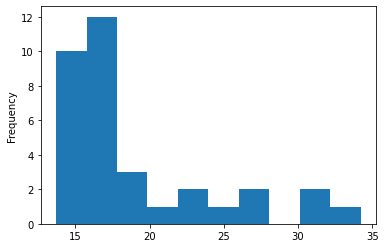

In [13]:
df['TX_POVERTY'].plot.hist()

# Create big csv 

In [14]:
dataframe_total = pd.DataFrame(columns=['code_INSEE','TX_POVERTY'])
for file in list_files:
    print("[[[{}]]] ".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    dataframe_total = pd.concat([dataframe_total,df])


[[[ Corse du Sud.xls]]] 
[[[ Drome.xls]]] 
[[[ Mayotte.xls]]] 
[[[ Taux de pauvreté/2019/430.xls]]] 
[[[ Taux de pauvreté/2019/740.xls]]] 
[[[ Taux de pauvreté/2019/940.xls]]] 
[[[ Taux de pauvreté/2019/650.xls]]] 
[[[ Alpes Maritime.xls]]] 
[[[ Taux de pauvreté/2019/730.xls]]] 
[[[ Isère.xls]]] 
[[[ Taux de pauvreté/2019/920.xls]]] 
[[[ Martinique.xls]]] 
[[[ Garonne.xls]]] 
[[[ Taux de pauvreté/2019/500.xls]]] 
[[[ Côte d'or.xls]]] 
[[[ Taux de pauvreté/2019/470.xls]]] 
[[[ Ardennes.xls]]] 
[[[ Landes.xls]]] 
[[[ Taux de pauvreté/2019/950.xls]]] 
[[[ Allier.xls]]] 
[[[ Taux de pauvreté/2019/530.xls]]] 
[[[ Ariège.xls]]] 
[[[ Taux de pauvreté/2019/580.xls]]] 
[[[ Marne.xls]]] 
[[[ Taux de pauvreté/2019/630.xls]]] 
[[[Maritime.xls]]] 
[[[ Gers.xls]]] 
[[[ Taux de pauvreté/2019/830.xls]]] 
[[[ Taux de pauvreté/2019/700.xls]]] 
[[[ Ardèche.xls]]] 
[[[Corse.xls]]] 
[[[ Charente.xls]]] 
[[[ Taux de pauvreté/2019/930.xls]]] 
[[[ Taux de pauvreté/2019/750.xls]]] 
[[[ Taux de pauvreté/2019/77

In [15]:
dataframe_total.head()

revenu_fiscal_ref,code_INSEE,TX_POVERTY
0,2A001,NaN
1,2A004,27.441333
2,2A006,17.826087
3,2A008,NaN
4,2A011,NaN


In [16]:
dataframe_total.describe()

revenu_fiscal_ref,TX_POVERTY
count,5596.000000
mean,24.800362
std,8.764831
min,9.387755
25%,18.236501
50%,23.165684
75%,30.123037
max,72.405498


In [17]:
dataframe_total.to_csv('../data/taux_pauvrete.csv',index=False)